In [965]:
import numpy as np
from scipy.interpolate import interp1d
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline, make_interp_spline
import splipy as sp
from scipy import stats
from scipy import optimize
from sklearn.decomposition import FactorAnalysis, PCA
from scipy.integrate import quad
from matplotlib.pyplot import cm
plt.rcParams['figure.figsize'] = [8., 6.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [966]:
xnew = np.linspace(-1, 1, num=101, endpoint=True)

# Load some angular acceptance models

In [967]:
# load different holeice models
h3 = pd.read_csv('/home/peller/retro/data/sampled_dom_angsens__hole_ice_model__as.h3-30cm.csv')
h3 = h3.values[1:].astype(np.float32)
h2 = pd.read_csv('/home/peller/retro/data/sampled_dom_angsens__hole_ice_model__as.h2-50cm.csv')
h2 = h2.values[1:].astype(np.float32)
h1 = pd.read_csv('/home/peller/retro/data/sampled_dom_angsens__hole_ice_model__as.h1-100cm.csv')
h1 = h1.values[1:].astype(np.float32)
nom = pd.read_csv('/home/peller/retro/data/sampled_dom_angsens__hole_ice_model__as.nominal.csv')
nom = nom.values[1:].astype(np.float32)

def msu(coseta, p1=0.3, p2=0):
    return 0.34 * (1 + 1.5 * coseta - coseta**3/2.) + p1 * coseta * (coseta**2 -1)**3 +p2 * np.exp(10*(coseta-1.2))

greco = msu(xnew, p1=(0.3+0.49*0.1), p2=-0.63)
dragon = msu(xnew, p1=(0.3-0.25*0.1), p2=-1.15)
dima = msu(xnew, p1=0.3, p2=0)
dima2 = msu(xnew, p1=0.2, p2=0)
dima3 = msu(xnew, p1=0.4, p2=0)
baseline = msu(xnew, p1=0.3, p2=1)
h3_model = h3[:,1]
h2_model = h2[:,1]
h1_model = h1[:,1]
nominal = nom[:,1]

# Approximate those by splines

greco bestfit
[0.         0.12461764 0.28905442 0.35603658 0.49794747 0.63547172
 0.61221285]
dragon bestfit
[0.         0.11344589 0.27288053 0.36435484 0.5126279  0.60388649
 0.55782465]
dima
[0.         0.11683799 0.27909729 0.36014204 0.50974393 0.6741596
 0.67870519]
dima-
[0.         0.10146521 0.25778366 0.37037138 0.53107924 0.67446301
 0.67913676]
dima+
[0.         0.13221035 0.30041105 0.3499128  0.48840847 0.673856
 0.67827345]
H3
[0.         0.11296154 0.2191295  0.42438193 0.64427818 0.40406461
 0.17507188]
H2
[0.         0.08666057 0.19440604 0.39575865 0.6295798  0.50077852
 0.28084327]
H1
[0.         0.06265704 0.18195267 0.35560009 0.62430838 0.6292279
 0.46680059]
nominal (lab)
[0.         0.04042336 0.15699203 0.30913611 0.56189404 0.89338296
 0.94409715]
new baseline
[0.         0.11644551 0.27987018 0.35870268 0.51187403 0.73533263
 0.78391259]


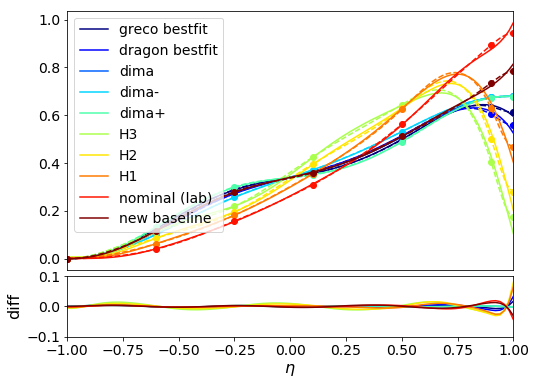

In [968]:
#support_x = np.array([-1., -0.25,  0.5,  0.9,  1.])
#initial_y = np.array([-0.1, 0.2, 0.5, 0.5, 0.5])

support_x = np.array([-1., -0.6, -0.25,  0.1, 0.5,  0.9,  1.])
initial_y = np.array([-0.1, 0.2, 0.2, 0.5, 0.5, 0.5, 0.5])

# this sets the derivative=0 boundary conditions
bc_type=([(1, 0.0)], [(1, 0.0)])
#bc_type=None

def fun(y, support_x, target):
    y[0] = 0
    cubic = make_interp_spline(support_x, y, bc_type=bc_type)
    diff = target - cubic(xnew)
    return np.sqrt(np.sum(np.square(diff)))


targets = [greco, dragon, dima, dima2, dima3, h3_model, h2_model, h1_model, nominal, baseline]
names = ['greco bestfit', 'dragon bestfit', 'dima', 'dima-', 'dima+', 'H3', 'H2', 'H1', 'nominal (lab)', 'new baseline']
colors = cm.jet(np.linspace(0,1,len(names)))

fig = plt.figure()
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=8, fig=fig)
ax2 = plt.subplot2grid((10,1), (8,0),sharex=ax1,rowspan=2, fig=fig)

y_points = []

for target, name, color in zip(targets, names, colors):
    
    opt = optimize.minimize(fun, x0=initial_y, method='L-BFGS-B', args=(support_x, target))
    y = opt['x']
    
    y_points.append(y)
    
    print name
    print y

    cubic = make_interp_spline(support_x, y, bc_type=bc_type)
    ax1.plot(support_x, y, 'o', c=color)
    ax1.plot(xnew, cubic(xnew), '--', c=color)
    ax1.plot(xnew, target, label=name, c=color)
    ax2.plot(xnew, cubic(xnew) - target, c=color)

y_points = np.stack(y_points)

ax1.set_xlim([-1,1])
ax2.set_xlim([-1,1])
ax1.get_xaxis().set_visible(False)

ax2.set_ylim([-0.1, 0.1])
ax2.hlines(1,-1,1)
ax2.set_ylabel('diff')
ax2.set_xlabel(r'$\eta$')

ax1.legend(loc='best')
plt.show()
fig.savefig('approx.png')

# Reduce dimensionality

In [969]:
transformer = PCA(n_components=2, random_state=0)
out = transformer.fit_transform(y_points)

In [970]:
out

array([[-0.02926301, -0.07233974],
       [ 0.03583656, -0.05619932],
       [-0.10244258, -0.04936436],
       [-0.0983376 , -0.01869094],
       [-0.10654736, -0.08003785],
       [ 0.48766964,  0.01280495],
       [ 0.34561247,  0.05642963],
       [ 0.11956742,  0.10117661],
       [-0.4303025 ,  0.14297412],
       [-0.22179302, -0.0367531 ]])

8.326672684688674e-18 3.954156792818044
-1.5959455978986624e-17 13.741111056751503


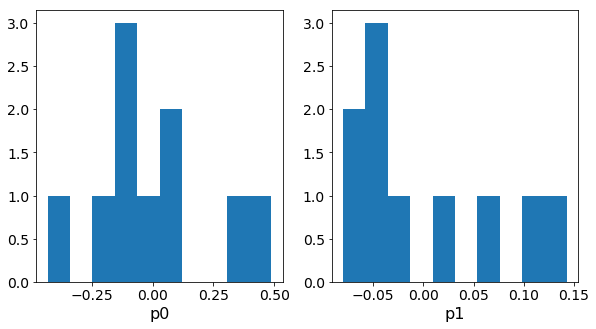

In [971]:
fig = plt.figure(figsize=(15,5))
for i in range(out.shape[1]):
    ax = plt.subplot2grid((1,out.shape[1]+1), (0,i), rowspan=1, fig=fig)
    ax.hist(out[:,i])
    ax.set_xlabel('p%i'%i)
    print np.mean(out[:,i]), 1./ np.std(out[:,i])
plt.savefig('dist.png')

In [972]:
transformer.inverse_transform(out) - y_points

array([[ 0.        ,  0.00210943,  0.00212646,  0.01110444,  0.00849127,
        -0.0036814 ,  0.00489242],
       [ 0.        ,  0.00874433,  0.00589598,  0.00820159,  0.01280649,
         0.00223533,  0.00205316],
       [ 0.        , -0.00012012, -0.0007898 , -0.00233315, -0.00179018,
         0.0005172 , -0.00086627],
       [ 0.        ,  0.00406964,  0.00040061, -0.01456104, -0.00543472,
         0.00871531, -0.00750045],
       [ 0.        , -0.00430944, -0.0019803 ,  0.00989467,  0.0018545 ,
        -0.00768085,  0.00576791],
       [ 0.        , -0.00645215,  0.00161021, -0.01084443, -0.01092762,
         0.00922021, -0.00862653],
       [ 0.        ,  0.00077724,  0.00197984, -0.00025984,  0.00616923,
        -0.00457478,  0.00358437],
       [ 0.        ,  0.00349845, -0.00822993,  0.01314169,  0.00153709,
        -0.00950005,  0.00752144],
       [ 0.        , -0.00140019,  0.00533186, -0.00019173,  0.00256915,
         0.00394373, -0.00197896],
       [ 0.        , -0.0069

In [973]:
# now then build a function with 2 parameters

def ang(params, values):
    transformed_params = transformer.inverse_transform(params)
    f = make_interp_spline(support_x, transformed_params, bc_type=bc_type)
    positive_f = lambda x : np.clip(f(x), 0., None)
    
    norm = quad(positive_f, -1, 1)
    out = positive_f(values)
    #normalize....why 0.68?
    out /= norm[0] / 0.68
    
    return out

# Samples & Envelope

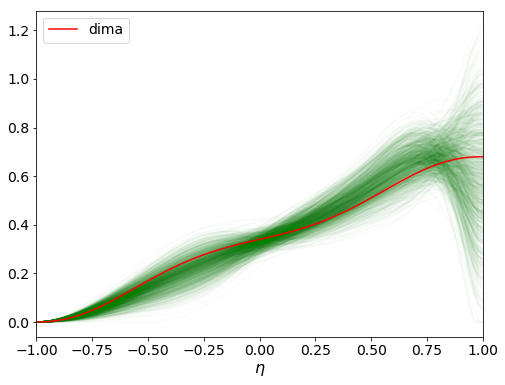

In [974]:
n = 1000

all_curves = np.ones(shape=(n, xnew.shape[0]))

for i in xrange(n):
    params = []
    for j in range(out.shape[1]):
        r = np.random.randn(1)
        params.append(r[0] * np.std(out[:,j]))
    all_curves[i] = ang(params, xnew)
    plt.plot(xnew, all_curves[i], c='green', alpha=20./n)
    #plt.plot(xnew, cubic(xnew), c='green', alpha=20./n)
                
plt.gca().set_xlim([-1,1])    
#plt.plot(xnew, msu(xnew, p1=0.2, p2=0), c='k')
plt.plot(xnew, msu(xnew, p1=0.3, p2=0), c='r', label='dima')
#plt.plot(xnew, msu(xnew, p1=0.4, p2=0), c='k')
plt.legend()
plt.gca().set_xlabel(r'$\eta$')
plt.savefig('rand.png')

In [975]:
p16 = np.percentile(all_curves, 16, axis=0)
p84 = np.percentile(all_curves, 86, axis=0)
p25 = np.percentile(all_curves, 2.5, axis=0)
p975 = np.percentile(all_curves, 97.5, axis=0)
p50 = np.percentile(all_curves, 50, axis=0)
#p0 = np.percentile(all_curves, 0, axis=0)
#p100 = np.percentile(all_curves, 100, axis=0)

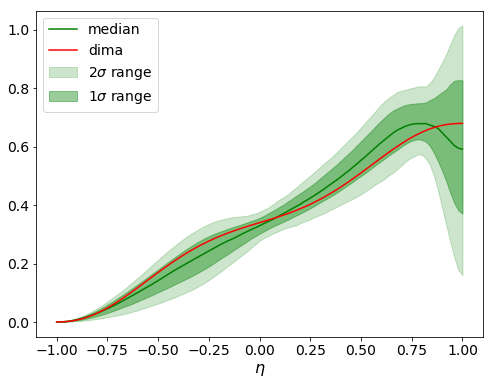

In [976]:
#plt.fill_between(xnew, p0, p100, alpha=0.1, color='green', label='IQ100')
plt.fill_between(xnew, p25, p975, alpha=0.2, color='green', label=r'2$\sigma$ range')
plt.fill_between(xnew, p16, p84, alpha=0.4, color='green', label=r'1$\sigma$ range')
plt.plot(xnew, p50, color='g', label='median')
plt.plot(xnew, dima, c='r', label='dima')
plt.gca().set_xlabel(r'$\eta$')
plt.legend(loc='upper left')
plt.savefig('envelope.png')

# Fit back to original models

greco bestfit
[-0.03978071 -0.07047931]
dragon bestfit
[ 0.02653745 -0.05789315]
dima
[-0.09962402 -0.05018682]
dima-
[-0.0848189  -0.02457809]
dima+
[-0.11444443 -0.07582192]
H3
[0.50219466 0.0063935 ]
H2
[0.34032261 0.05693239]
H1
[0.10941801 0.10487416]
nominal (lab)
[-0.42569492  0.13797562]
new baseline
[-0.2060803  -0.03791859]


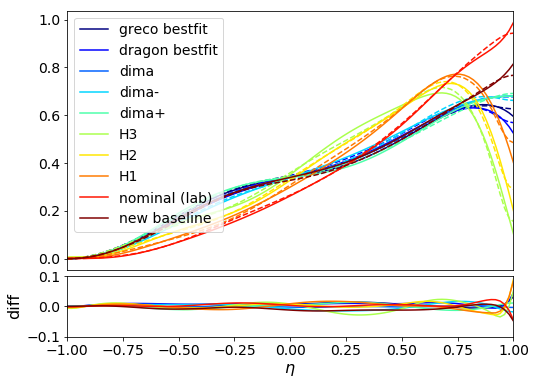

In [977]:
def fun(params, target):
    diff = ang(params, xnew) - target
    return np.sqrt(np.sum(np.square(diff)))

fig = plt.figure()
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=8, fig=fig)
ax2 = plt.subplot2grid((10,1), (8,0),sharex=ax1,rowspan=2, fig=fig)

approx_params = []

for target, name, color in zip(targets, names, colors):
    
    opt = optimize.minimize(fun, x0=np.zeros(out.shape[1]), method='L-BFGS-B', args=(target)) 
    approx_params.append(opt['x'])
    print name
    print opt['x']

    new = ang(opt['x'], xnew)
    ax1.plot(xnew, new, '--', c=color)
    ax1.plot(xnew, target, label=name, c=color)
    ax2.plot(xnew, new - target, c=color)

approx_params = np.stack(approx_params)

ax1.set_xlim([-1,1])
ax2.set_xlim([-1,1])
ax1.get_xaxis().set_visible(False)

ax2.set_ylim([-0.1, 0.1])
ax2.hlines(1,-1,1)
ax2.set_ylabel('diff')
ax2.set_xlabel(r'$\eta$')

ax1.legend(loc='upper left')
plt.show()
fig.savefig('approx_new.png')

# morph from one to another model

/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


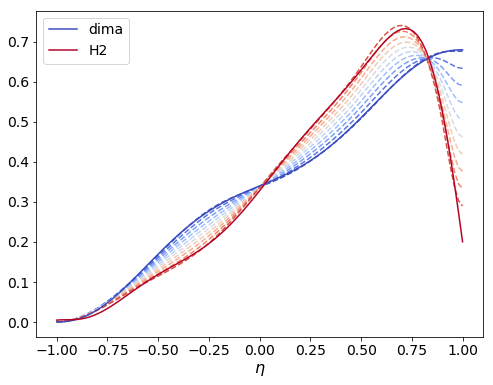

In [978]:
# let's go from dima to H2
n = 10.
p1 = np.linspace(approx_params[2,0], approx_params[6,0], n, endpoint=True)
p2 = np.linspace(approx_params[2,1], approx_params[6,1], n, endpoint=True)

cmap = cm.coolwarm

for i in range(int(n)):
    plt.plot(xnew, ang([p1[i],p2[i]], xnew), c=cmap(i/n), ls='--')
    
plt.plot(xnew, dima, color=cmap(0.), label='dima')
plt.plot(xnew, h2_model, color=cmap(1.), label='H2')
plt.legend()
plt.gca().set_xlabel(r'$\eta$')

plt.savefig('morph.png')